In [1]:
import os, sys
import os.path as osp
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from models.graphconv import Net
from metrics.metrics import get_metrics, create_confusion_matrix
from utils.dataset import MemoryDataset
from utils.params import reset_weights

import torch.nn as nn
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_sort_pool as gsp

In [2]:
CATEGORIES3 = {"cns": 0, "antineoplastic": 1, "cardio": 2}

CATEGORIES5 = {"cns": 0, "antineoplastic": 1, "cardio": 2, "gastrointestinal": 3, "antiinfective": 4}

CATEGORIES12 = {"cns": 0, "antineoplastic": 1, "cardio": 2, "gastrointestinal": 3, "antiinfective": 4, 
                "reproductivecontrol": 5, "lipidregulating": 6, "hematologic": 7, "respiratorysystem": 8,
               "antiinflammatory": 9, "urological": 10, "dermatologic": 11}

In [3]:
LR = 0.001
GPU = 0
NUM_SPLITS = 5
BATCH_SIZE = 256
WORKERS = 12

NUM_CLASSES = 12 # 3, 5 or 12

BASE_DIR = os.getcwd()
DATA_DIR = osp.join(BASE_DIR, 'data')
RAW_DATA_DIR = osp.join(DATA_DIR, "drugclass_rmsalts_rmoverlap")
RAW_DATA_FILE = osp.join(RAW_DATA_DIR, f'{NUM_CLASSES}cls_rmsaltol.csv')
PROCESSED_DATA_DIR = osp.join(DATA_DIR, 'processed')
DATA_PATH = osp.join(PROCESSED_DATA_DIR, f'{NUM_CLASSES}_rmsaltol_data')
SAVED_MODELS_DIR = osp.join(BASE_DIR, 'saved_models')
net_name = f"GraphConv_{NUM_CLASSES}"

In [4]:
if NUM_CLASSES == 3:
    CATEGORIES = CATEGORIES3
    neighbors = 15
    dist = 0.1 # 0.25
    metric = "euclidean"
    
elif NUM_CLASSES == 5:
    CATEGORIES = CATEGORIES5
    neighbors = 30
    dist = 0.5
    metric = "euclidean"

    
elif NUM_CLASSES == 12:
    CATEGORIES = CATEGORIES12
    neighbors = 50
    dist = 0.5 # 0.1
    metric = "euclidean" #"dice"
    
    
else:
    CATEGORIES = CATEGORIES12
    neighbors = 50
    dist = 0.5 # 0.1
    metric = "euclidean" #"dice"

In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_outs = torch.Tensor()
    total_labels = torch.Tensor()
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1) 
        total_preds = torch.cat((total_preds, pred.cpu()), 0)
        total_outs = torch.cat((total_outs, out.cpu()), 0)
        total_labels = torch.cat((total_labels, data.y.cpu()), 0)
    return total_labels, total_preds, total_outs

In [6]:
device = torch.device(f'cuda:{GPU}' if torch.cuda.is_available() else 'cpu')
dataset = MemoryDataset(root=DATA_PATH, transform=T.NormalizeFeatures()) # 

In [7]:
dataset[0].num_features

10

# Validation Metrics

In [8]:
all_indices = [i for i in range(0, len(dataset))]
acc_lst, bal_acc_lst, mcc_lst, apc_lst, aucroc_lst = [],[],[],[],[] 
for fold in range(NUM_SPLITS):
    if fold == 4: # remove this condition to get metrics for all folds 
        val_file = osp.join(RAW_DATA_DIR, f"{NUM_CLASSES}cls_val_ids{fold}.csv")
        data = pd.read_csv(val_file)
        df = pd.DataFrame(data)
        val_indices = [index[0] for index in df.values.tolist() if index[0] <= len(dataset) - 1]
        val_set = set(val_indices)
        full_set = set(all_indices)
        train_set = full_set.difference(val_set)
        train_indices = list(train_set)
        train_data = dataset[train_indices]
        val_data = dataset[val_indices]

        train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True,
                                      drop_last=False, num_workers=WORKERS)

        val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False,
                                    drop_last=False, num_workers=WORKERS)


        SAVED_MODEL_PATH = osp.join(SAVED_MODELS_DIR, f"{net_name}_fold_{fold}.pt")
        checkpoint = torch.load(SAVED_MODEL_PATH, map_location=torch.device(device))
        vmodel = Net(dataset[0].num_features, 1024, NUM_CLASSES).to(device)
        vmodel.load_state_dict(checkpoint)


        vlabels, vpreds, vouts = evaluate(vmodel, val_loader)
        val_acc, val_bal_acc, val_mcc, val_apc, val_aucroc = get_metrics(vlabels, vpreds, vouts, NUM_CLASSES)
        acc_lst.append(val_acc) 
        bal_acc_lst.append(val_bal_acc) 
        mcc_lst.append(val_mcc) 
        apc_lst.append(val_apc)
        aucroc_lst.append(val_aucroc)
        print(f'Fold: {fold} | acc: {val_acc:.4f} | bal_acc: {val_bal_acc:.4f} | mcc: {val_mcc:.4f} |'
                      f' aucroc: {val_aucroc:.4f} | apc: {val_apc:.4f}  ')

print("\n-----------------------------------------------------------------------------------------")
print(f'acc: {np.mean(acc_lst):.4f}+-{np.std(acc_lst):.4f} |'
      f'bal_acc: {np.mean(bal_acc_lst):.4f}+-{np.std(bal_acc_lst):.4f} | '
      f'mcc: {np.mean(mcc_lst):.4f}+-{np.std(mcc_lst):.4f} |'
      f' aucroc: {np.mean(aucroc_lst):.4f}+-{np.std(aucroc_lst):.4f} |'
      f'apc: {np.mean(apc_lst):.4f}+-{np.std(apc_lst):.4f}')

Fold: 4 | acc: 0.8697 | bal_acc: 0.7799 | mcc: 0.8359 | aucroc: 0.9869 | apc: 0.9373  

-----------------------------------------------------------------------------------------
acc: 0.8697+-0.0000 |bal_acc: 0.7799+-0.0000 | mcc: 0.8359+-0.0000 | aucroc: 0.9869+-0.0000 |apc: 0.9373+-0.0000


## Confusion Matrix

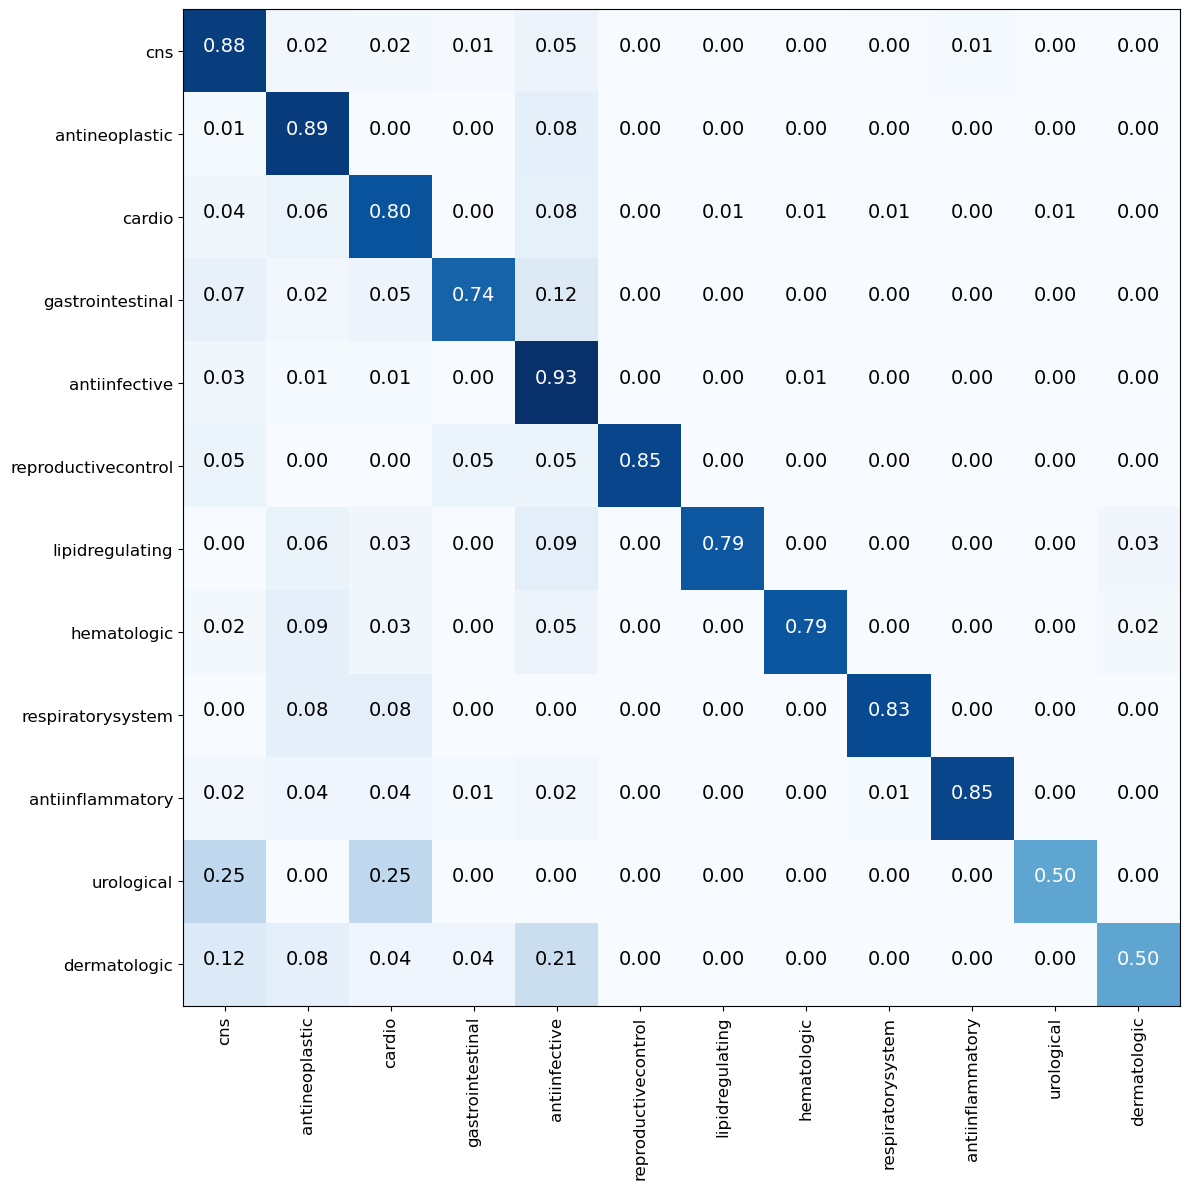

In [9]:
create_confusion_matrix(vlabels, vpreds, NUM_CLASSES, "valid", normalize='true')

# Test Metrics

In [10]:
PUBCHEMDATA_DIR = osp.join(DATA_DIR, 'PubChemData')
PUBCHEM_PROC_DIR = osp.join(PUBCHEMDATA_DIR, 'processed')

In [11]:
TEST_DATA_PATH = osp.join(PUBCHEM_PROC_DIR, f'Test_{NUM_CLASSES}_rmsaltol_data')

In [12]:
test_dataset = MemoryDataset(root=TEST_DATA_PATH, transform=T.NormalizeFeatures())

In [13]:
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                drop_last=False, num_workers=WORKERS)

In [14]:
acc_lst, bal_acc_lst, mcc_lst, apc_lst, aucroc_lst = [],[],[],[],[] 
for fold in range(NUM_SPLITS):
    if fold == 4:
        SAVED_MODEL_PATH = osp.join(SAVED_MODELS_DIR, f"{net_name}_fold_{fold}.pt")
        checkpoint = torch.load(SAVED_MODEL_PATH, map_location=torch.device(device))
        model = Net(dataset[0].num_features, 1024, NUM_CLASSES).to(device)
        model.load_state_dict(checkpoint)

        labels, preds, outs = evaluate(model, test_loader)
        acc, bal_acc, mcc, apc, aucroc = get_metrics(labels, preds, outs, NUM_CLASSES)
        acc_lst.append(acc) 
        bal_acc_lst.append(bal_acc) 
        mcc_lst.append(mcc) 
        apc_lst.append(apc)
        aucroc_lst.append(aucroc)
        print(f'Fold: {fold} | acc: {acc:.4f} | bal_acc: {bal_acc:.4f} | mcc: {mcc:.4f} | aucroc: {aucroc:.4f} | apc: {apc:.4f}')

print("\n-----------------------------------------------------------------------------------------")
print(f'acc: {np.mean(acc_lst):.4f}+-{np.std(acc_lst):.4f} |'
  f'bal_acc: {np.mean(bal_acc_lst):.4f}+-{np.std(bal_acc_lst):.4f} | '
  f'mcc: {np.mean(mcc_lst):.4f}+-{np.std(mcc_lst):.4f} |'
  f' aucroc: {np.mean(aucroc_lst):.4f}+-{np.std(aucroc_lst):.4f} |'
  f'apc: {np.mean(apc_lst):.4f}+-{np.std(apc_lst):.4f}')

Fold: 4 | acc: 0.8706 | bal_acc: 0.8067 | mcc: 0.8213 | aucroc: 0.9685 | apc: 0.8723

-----------------------------------------------------------------------------------------
acc: 0.8706+-0.0000 |bal_acc: 0.8067+-0.0000 | mcc: 0.8213+-0.0000 | aucroc: 0.9685+-0.0000 |apc: 0.8723+-0.0000


In [15]:
#testlabels = [data.y.item() for data in test_dataset]

In [16]:
#len(testlabels)

In [17]:
#trainlabels = [data.y.item() for data in dataset]

In [18]:

# for name, label in CATEGORIES.items():
#     print(f"{name} | train: {trainlabels.count(label)}| test: {testlabels.count(label)} | test ratio: {testlabels.count(label)/(testlabels.count(label) + trainlabels.count(label)):.2f} ")

## Confusion Matrix - Test Data

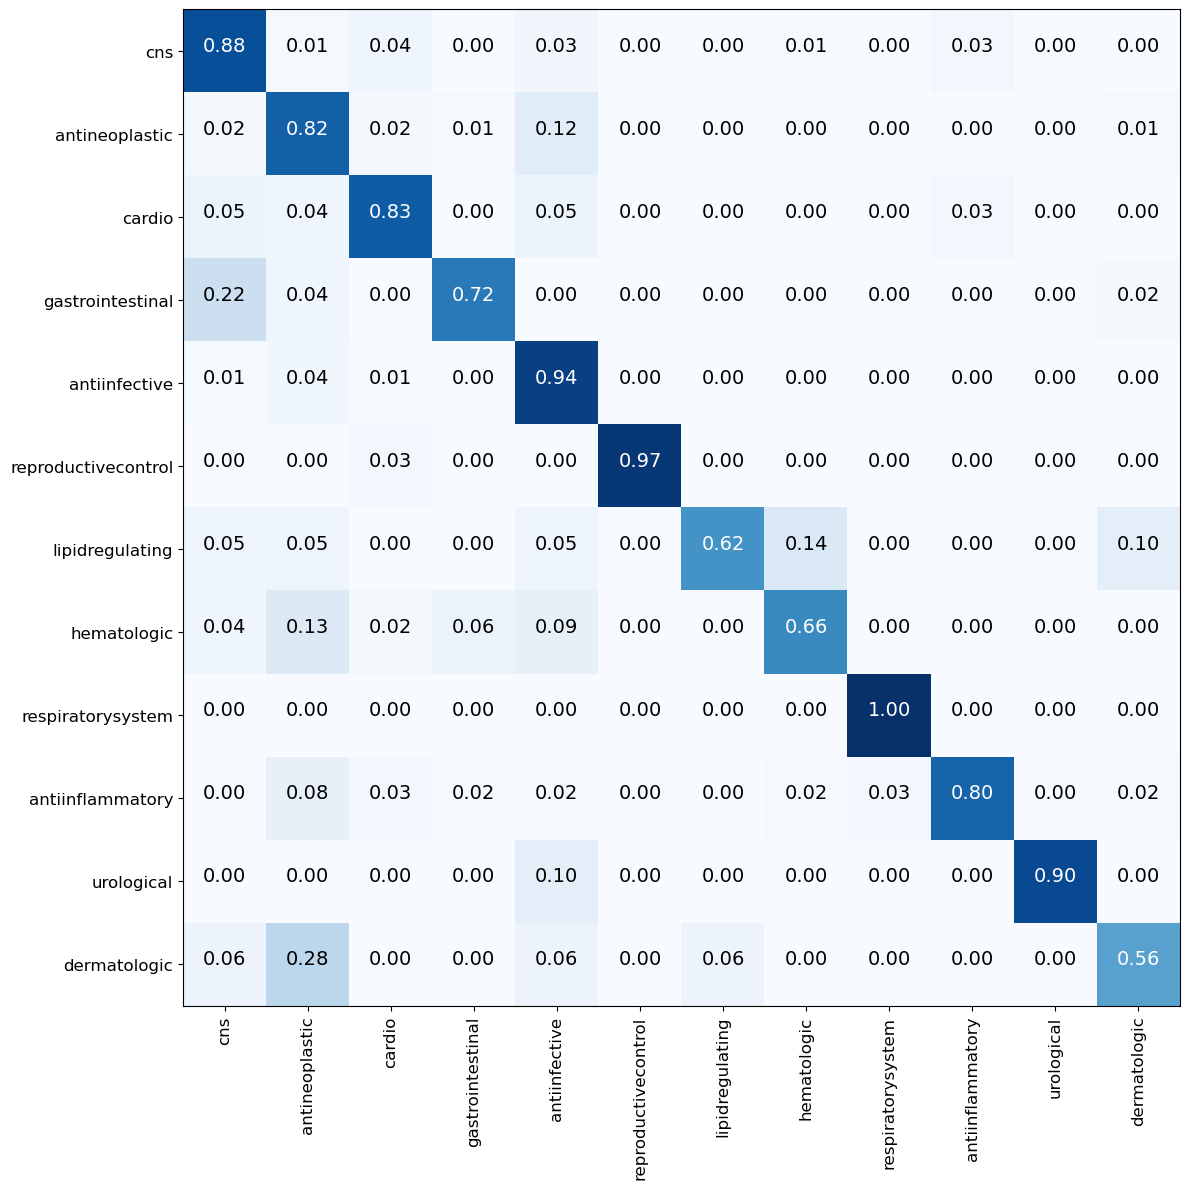

In [19]:
create_confusion_matrix(labels, preds, NUM_CLASSES, "test", normalize='true')